# Task 1 - Image Segmentation

In this notebook is specified the training process and preprocessing techniques that are used to solve segmentation problem. For this task I decided to not invent the wheel and use already predefined model ResNet50 which will be described further in report. Generally task can be divided in following steps

In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50
from entities.base_transform import BaseTransform
from entities.custom_loss import CombinedLoss
from entities.dataset import EyeglassDataset
from entities.joint_transform import JointTransform
from entities.utils import calculate_f1_tensor
import torchvision.transforms as transforms
from PIL import Image



# Report


## 1. Data Preprocessing

I have create a custom class that augments train images to increase training accuracy.
One of it is augmented, this will also increase f1 score



In [4]:
base_dataset = EyeglassDataset(
    images_dir='./data/train/images',
    masks_dir='./data/train/masks',
    transform=BaseTransform())

train_dataset = EyeglassDataset(
    images_dir='./data/train/images',
    masks_dir='./data/train/masks',
    transform=JointTransform())


train_dev_sets = torch.utils.data.ConcatDataset([base_dataset, train_dataset])
train_loader = DataLoader(train_dev_sets, batch_size=8, shuffle=True)

In [5]:
val_dataset = EyeglassDataset(
    images_dir='./data/val/images',
    masks_dir='./data/val/masks',
    transform=BaseTransform()
)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

test_dataset = EyeglassDataset(
    images_dir='./data/test/images',
    masks_dir='./data/test/masks',
    transform=BaseTransform()
)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

## 2. Model Selection

I choose Resnet50 model as standard Unet for image segmentation,

ResNet-50 is used as the backbone for feature extraction. ResNet (Residual Network) uses residual connections to facilitate the training of deeper networks. Key components of ResNet-50 include:

Convolutional Layers: Initial layers that capture low-level features.

Residual Blocks: These blocks consist of convolutional layers with shortcut connections that allow gradients to flow through the network without vanishing or exploding.

ResNet-50 has 4 stages of residual blocks:
- Stage 1: conv1 - a 7x7 convolution followed by max pooling.
- Stage 2: conv2_x - consists of 3 residual blocks with 3x3 convolutions.
- Stage 3: conv3_x - consists of 4 residual blocks with 3x3 convolutions.
- Stage 4: conv4_x - consists of 6 residual blocks with 3x3 convolutions.
- Stage 5: conv5_x - consists of 3 residual blocks with 3x3 convolutions.

These stages progressively reduce the spatial dimensions and increase the depth of the feature maps, capturing more abstract representations of the input image.

This is the representation of architecture on image:

![Alt text](https://assets-global.website-files.com/645cec60ffb18d5ebb37da4b/65eb303c9ee4b67135628e9a_archi.jpg)

In [6]:
model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = CombinedLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 147MB/s]


## 3. Training

In the training phase, we use an augmented dataset and train the model for 15 epochs. This number of epochs was chosen based on empirical experiments, where we observed that key metrics stabilized and showed minimal improvement beyond this point.

We employ **Binary Cross-Entropy Loss (BCELoss)** as our primary loss function, which is well-suited for binary classification tasks common in machine learning and deep learning. BCELoss is ideal for segmentation tasks where the mask pixels can be represented as 1 for white segments and 0 for black segments. BCELoss measures how closely the model’s predicted probabilities match the actual binary labels, optimizing the model’s performance in identifying the correct segmentation.

To enhance the segmentation accuracy, particularly in reducing false positives and false negatives, we incorporate **F1 Loss**. The F1 score balances precision and recall, providing a single metric that captures both false positives and false negatives.

The F1 score is calculated as follows:

$$ \text{F1 score} = \frac{2 \cdot (\text{precision} \cdot \text{recall})}{\text{precision} + \text{recall}} $$


By combining BCELoss and F1 Loss, we aim to optimize the model not only for overall accuracy but also for the balance between precision and recall in segmentation tasks.

---

In [7]:
num_epochs = 15
train_loss_history, validation_loss_history, f1_history = [], [], []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    print(f"Epoch {epoch+1}/{num_epochs} Training:")
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}", unit="batch") as pbar:
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)['out']
            
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
            pbar.update(1)

    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    
    val_loss = 0
    f1 = 0
    model.eval()
    with torch.no_grad():
        print(f"Epoch {epoch+1}/{num_epochs} Validation:")
        with tqdm(total=len(val_loader), desc=f"Validating", unit="batch") as pbar:
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)['out']
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                pbar.update(1)
                
                dice = calculate_f1_tensor(outputs, masks)
                
                f1 += dice.item()
                

    val_loss /= len(val_loader)
    f1 /= len(val_loader)
    validation_loss_history.append(val_loss)
    f1_history.append(f1)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, F1 score: {f1:.4f}")


torch.save(model.state_dict(), './model/eyeglass_segmentation_model.pth')

Epoch 1/15 Training:


Epoch 1:   0%|          | 0/498 [00:00<?, ?batch/s]

Epoch 1/15 Validation:


Validating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 1/15: Training Loss: 1.6827, Validation Loss: 1.6286, F1 score: 0.4546
Epoch 2/15 Training:


Epoch 2:   0%|          | 0/498 [00:00<?, ?batch/s]

Epoch 2/15 Validation:


Validating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 2/15: Training Loss: 1.6164, Validation Loss: 1.6085, F1 score: 0.6410
Epoch 3/15 Training:


Epoch 3:   0%|          | 0/498 [00:00<?, ?batch/s]

Epoch 3/15 Validation:


Validating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 3/15: Training Loss: 1.6054, Validation Loss: 1.6033, F1 score: 0.7137
Epoch 4/15 Training:


Epoch 4:   0%|          | 0/498 [00:00<?, ?batch/s]

Epoch 4/15 Validation:


Validating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 4/15: Training Loss: 1.6018, Validation Loss: 1.6008, F1 score: 0.7562
Epoch 5/15 Training:


Epoch 5:   0%|          | 0/498 [00:00<?, ?batch/s]

Epoch 5/15 Validation:


Validating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 5/15: Training Loss: 1.6001, Validation Loss: 1.5994, F1 score: 0.7806
Epoch 6/15 Training:


Epoch 6:   0%|          | 0/498 [00:00<?, ?batch/s]

Epoch 6/15 Validation:


Validating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 6/15: Training Loss: 1.5988, Validation Loss: 1.5985, F1 score: 0.7973
Epoch 7/15 Training:


Epoch 7:   0%|          | 0/498 [00:00<?, ?batch/s]

Epoch 7/15 Validation:


Validating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 7/15: Training Loss: 1.5980, Validation Loss: 1.5982, F1 score: 0.8046
Epoch 8/15 Training:


Epoch 8:   0%|          | 0/498 [00:00<?, ?batch/s]

Epoch 8/15 Validation:


Validating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 8/15: Training Loss: 1.5974, Validation Loss: 1.5972, F1 score: 0.8213
Epoch 9/15 Training:


Epoch 9:   0%|          | 0/498 [00:00<?, ?batch/s]

Epoch 9/15 Validation:


Validating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 9/15: Training Loss: 1.5969, Validation Loss: 1.5975, F1 score: 0.8202
Epoch 10/15 Training:


Epoch 10:   0%|          | 0/498 [00:00<?, ?batch/s]

Epoch 10/15 Validation:


Validating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 10/15: Training Loss: 1.5966, Validation Loss: 1.5966, F1 score: 0.8327
Epoch 11/15 Training:


Epoch 11:   0%|          | 0/498 [00:00<?, ?batch/s]

Epoch 11/15 Validation:


Validating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 11/15: Training Loss: 1.5962, Validation Loss: 1.5966, F1 score: 0.8321
Epoch 12/15 Training:


Epoch 12:   0%|          | 0/498 [00:00<?, ?batch/s]

Epoch 12/15 Validation:


Validating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 12/15: Training Loss: 1.5961, Validation Loss: 1.5963, F1 score: 0.8383
Epoch 13/15 Training:


Epoch 13:   0%|          | 0/498 [00:00<?, ?batch/s]

Epoch 13/15 Validation:


Validating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 13/15: Training Loss: 1.5959, Validation Loss: 1.5960, F1 score: 0.8419
Epoch 14/15 Training:


Epoch 14:   0%|          | 0/498 [00:00<?, ?batch/s]

Epoch 14/15 Validation:


Validating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 14/15: Training Loss: 1.5957, Validation Loss: 1.5959, F1 score: 0.8460
Epoch 15/15 Training:


Epoch 15:   0%|          | 0/498 [00:00<?, ?batch/s]

Epoch 15/15 Validation:


Validating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 15/15: Training Loss: 1.5956, Validation Loss: 1.5956, F1 score: 0.8499


## 4. Metrics

To detect if model was trained correctly I used standard ML metrics: training loss, validation loss and f1 score. As it was mentioned before  I have created combined loss function that encapsulates 

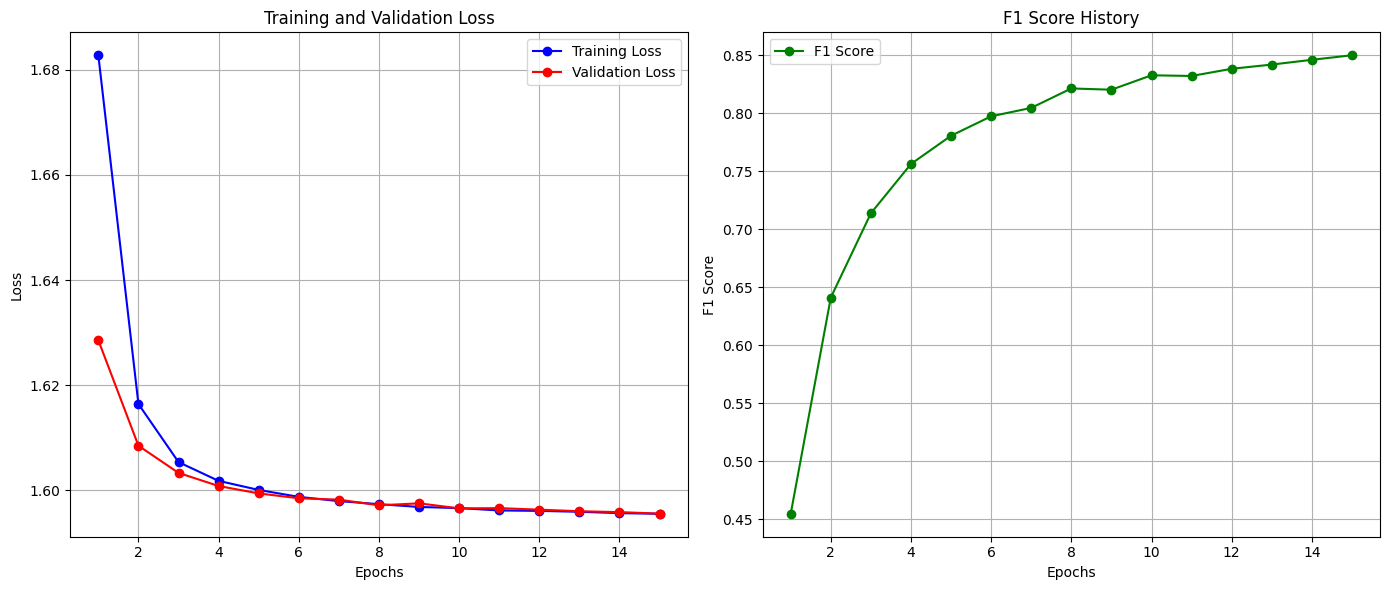

In [8]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss_history, 'b-o', label='Training Loss')
plt.plot(range(1, num_epochs+1), validation_loss_history, 'r-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), f1_history, 'g-o', label='F1 Score')
plt.title('F1 Score History')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

We can see that after 15 epochs f1 score is pretty high. 


## 5. Visualisations

To visualise images we will use test dataset side by side with their ground truth masks and predicted masks

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3611329].


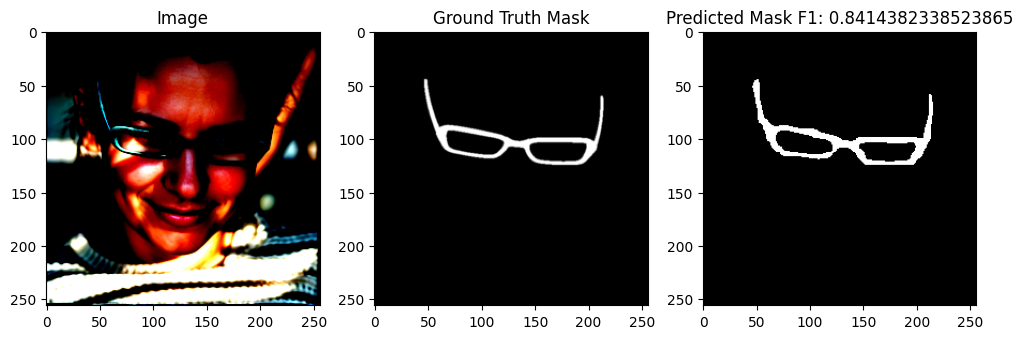

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.5179958].


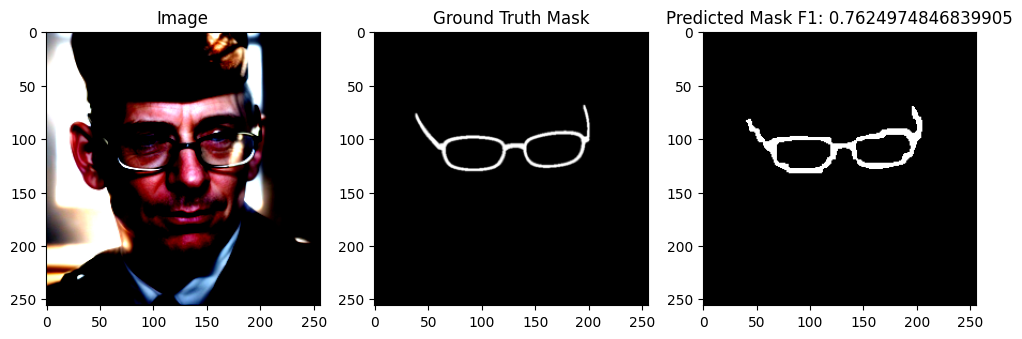

In [11]:
def visualize_results(model, dataset):
    model.eval()
    with torch.no_grad():
        for image, mask in dataset:
            image, masks= image.to(device), mask.to(device)
            output = model(image)['out']
            

            dice = calculate_f1_tensor(output, masks)
       
            output = torch.sigmoid(output).cpu().numpy()[0][0]

            image = image.cpu().numpy()[0].transpose((1, 2, 0))
            mask = mask.cpu().numpy()[0].transpose((1, 2, 0))
            
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title('Image')
            plt.subplot(1, 3, 2)
            plt.imshow(mask, cmap='gray')
            plt.title('Ground Truth Mask')
            plt.subplot(1, 3, 3)
            plt.imshow(output > 0.4, cmap='gray')
            plt.title(f'Predicted Mask F1: {dice}')
            plt.show()


visualize_results(model, test_loader)

# Additional: Loading and using model on CPU

Some of us has GPU ... but someone doesn't. Let's help those guys and image segmentation it on CPU. 
For that purpose let's use really cool image, not just regular ones that we have in dataset

First save it

In [10]:
device = torch.device("cpu")


In [ ]:
model = model.to(device)
torch.save(model.state_dict(), 'model_cpu.pth')

now we should be able to read it

/Users/yuriivoievidka/MLProjects/IT-jim/Test Task/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yuriivoievidka/MLProjects/IT-jim/Test Task/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


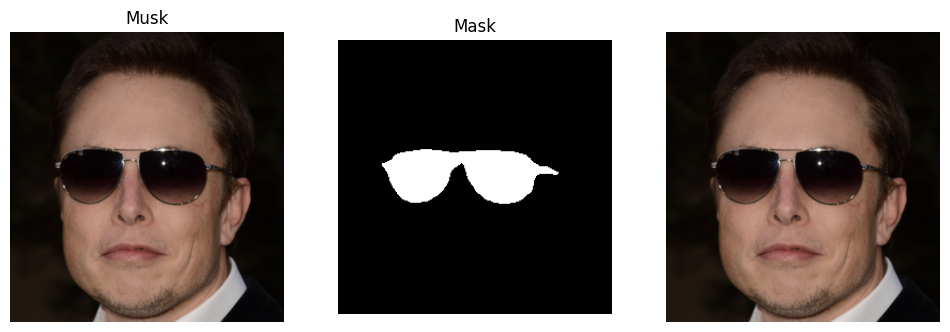

In [2]:
model_cpu = deeplabv3_resnet50(pretrained=False)
model_cpu.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1))

state_dict = torch.load('./model/eyeglass_segmentation_model.pth', map_location=torch.device('cpu'))
model_cpu.load_state_dict(state_dict, strict=False)
model_cpu = model_cpu.to('cpu')

model_cpu.eval()

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

image = Image.open('./data/musk.png').convert("RGB")

input_tensor = transform(image).unsqueeze(0)

with torch.no_grad():
    output = model_cpu(input_tensor)['out']
    output = torch.sigmoid(output).numpy()

output_mask = (output > 0.5).astype('uint8')

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(image)
plt.title('Musk')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(output_mask[0][0] > 0.4, cmap='gray')
plt.title('Mask')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(image)
plt.title(f'')
plt.show()